In [1]:
import pathlib
import sys
import os

# Hacky way to get to root package
if "notebooks" in os.getcwd():
    os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
    
import sys
from data_container import load_scouted_data, load_pit_data, get_Teams_in_Match
import pandas as pd
import numpy as np
import plotly.express as px
pd.set_option('display.max_columns', None)

In [3]:
scouted_data = load_scouted_data()
scouted_data


,Scouter Initials,Match Number,Team Number,No Show,Auto Fuel,Auto Climbing Status,Auto Human Player Score,Teleop Fuel,Teleop Fuel Passed,Endgame Climbing Level
0,abc,1,5045,True,3,False,6,131,26,L1
1,abc,1,5744,False,14,True,12,49,27,L1
2,abc,1,4630,True,10,True,10,20,12,NaN
3,abc,1,21,False,13,False,6,152,35,L2
4,abc,1,3824,True,9,True,2,175,22,L1
...,...,...,...,...,...,...,...,...,...,...
163,abc,28,4467,False,0,True,14,150,162,NaN
164,abc,28,3843,True,10,False,10,191,22,L3
165,abc,28,3937,True,5,False,9,100,66,L1
166,abc,28,4576,False,14,False,13,181,53,NaN


In [4]:
pit_data = load_pit_data()
pit_data

,Scouter Initials,Team Number,Intake,Climbing Level (Auto),Climbing Level (Endgame),Auto Start,Piece Auto,Climb type,Over Bumper?,Under Trench?,Carrying Capacity,Preload Number,Defense Skill (0-5)
0,abc,3504,Ground,1,1,right,16,in,True,False,8,8,2
1,abc,8393,Depot,0,2,right,6,in,False,True,12,6,1
2,abc,67,Ground,1,3,middle,3,out,True,True,6,3,4
3,abc,1678,Human Player Station,0,1,left,8,out,False,True,10,4,3
4,abc,118,Ground,1,1,left,0,in,True,True,10,0,5
5,abc,254,Human Player Station,1,0,middle,8,out,False,True,8,8,1
6,abc,2056,Depot,1,0,left,9,out,True,False,12,8,2


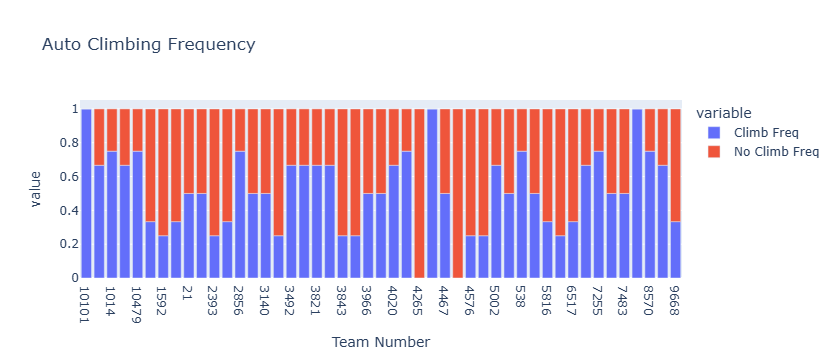

In [5]:
auto_climbing_status_df = scouted_data.groupby("Team Number")["Auto Climbing Status"].value_counts().unstack(fill_value=0).reset_index()
auto_climbing_status_df["Climb Freq"] = auto_climbing_status_df[True] / (auto_climbing_status_df[True] + auto_climbing_status_df[False])
auto_climbing_status_df["No Climb Freq"] = auto_climbing_status_df[False] / (auto_climbing_status_df[True] + auto_climbing_status_df[False])
fig = px.bar(auto_climbing_status_df, x = "Team Number", y = ["Climb Freq", "No Climb Freq"], title = "Auto Climbing Frequency")
fig.show()

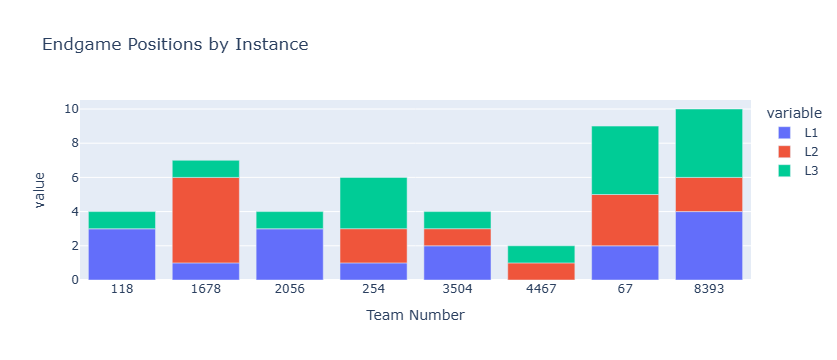

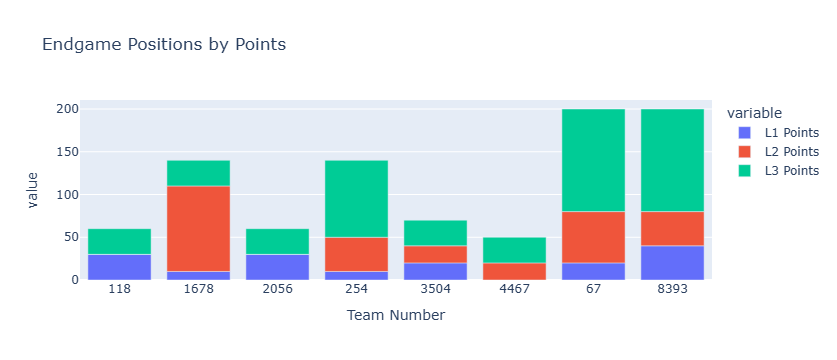

In [6]:
avg_team = scouted_data.groupby("Team Number").mean(numeric_only = True)
# print(avg_team)
endgame_df = scouted_data.groupby("Team Number")["Endgame Climbing Level"].value_counts().unstack(fill_value=0).reset_index()
endgame_df["L1 Points"] = endgame_df["L1"] * 10
endgame_df["L2 Points"] = endgame_df["L2"] * 20
endgame_df["L3 Points"] = endgame_df["L3"] * 30
# print(endgame_df)
fig = px.bar(endgame_df, x = "Team Number", y = ["L1", "L2", "L3"], title = "Endgame Positions by Instance")
fig.show()
fig = px.bar(endgame_df, x = "Team Number", y = ["L1 Points", "L2 Points", "L3 Points"], title = "Endgame Positions by Points")
fig.show()

    index Scouter Initials Match Number Team Number  No Show  Auto Fuel  \
0       0              abc            1        1678    False         14   
1       1              abc            1        3504     True         15   
2       2              abc            1        8393    False         13   
3       3              abc            1         118     True          9   
4       4              abc            1         254     True          4   
5       5              abc            1          67    False         12   
6       6              abc            2        8393    False          7   
7       7              abc            2          67     True         15   
8       8              abc            2         118     True          3   
9       9              abc            2        1678    False          2   
10     11              abc            2        3504    False         24   
11     12              abc            3          67    False          6   
12     14              ab

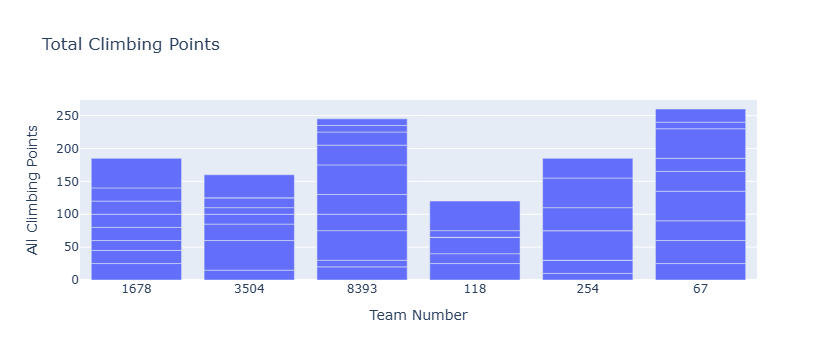

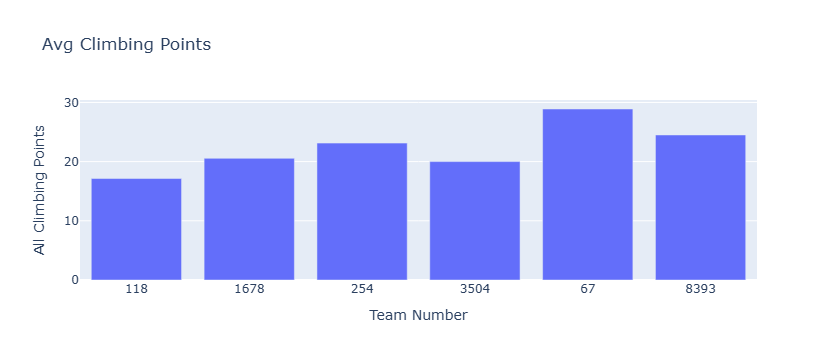

In [7]:
teams = get_Teams_in_Match()

match_data = scouted_data.loc[scouted_data["Team Number"].isin(teams)].reset_index()
match_data["Auto Climbing Status"] = match_data["Auto Climbing Status"].fillna(False)
if match_data["Auto Climbing Status"].dtype == 'object':
    match_data["Auto Climbing Status"] = match_data["Auto Climbing Status"].astype(str).str.lower().isin(['true', '1', 'yes'])
match_data["Auto Climb Points"] = match_data["Auto Climbing Status"].apply(lambda x: 15 if x else 0)

def convert_endgame_to_teleop(level):
    if pd.isna(level):
        return 0
    level_str = str(level).upper().strip()
    if level_str == "L1":
        return 10
    elif level_str == "L2":
        return 20
    elif level_str == "L3":
        return 30
    else:
        return 0

match_data["Endgame Teleop Points"] = match_data["Endgame Climbing Level"].apply(convert_endgame_to_teleop)

match_data["All Climbing Points"] = match_data["Auto Climb Points"] + match_data["Endgame Teleop Points"]
print(match_data)

# fix this (dividing but one more than the number of matches a team is in)
avg_match_data = match_data.groupby("Team Number").mean(numeric_only = True).reset_index()
print(avg_match_data)
fig = px.bar(match_data, x = "Team Number", y = "All Climbing Points", title = "Total Climbing Points")
fig.show()

fig = px.bar(avg_match_data, x = "Team Number", y = "All Climbing Points", title = "Avg Climbing Points")
fig.show()

In [8]:
scouted_data[scouted_data["Team Number"] == "1678"]

,Scouter Initials,Match Number,Team Number,No Show,Auto Fuel,Auto Climbing Status,Auto Human Player Score,Teleop Fuel,Teleop Fuel Passed,Endgame Climbing Level
0,abc,1,1678,False,14,True,12,49,27,L1
9,abc,2,1678,False,2,False,1,198,3,L2
17,abc,3,1678,True,6,False,8,108,13,NaN
19,abc,4,1678,False,7,True,5,183,33,NaN
26,abc,5,1678,False,8,False,3,55,81,L2
41,abc,7,1678,True,2,False,15,68,125,L2
42,abc,8,1678,False,4,False,8,170,56,L2
50,abc,9,1678,True,7,False,1,14,124,L2
57,abc,10,1678,False,1,True,14,168,96,L3
